In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys

import pymaster as nmt

#sys.path.insert(0, '/home/aew492/lss-dipoles')
#sys.path.insert(0, '/home/investigator/code/lss-dipoles')
sys.path.insert(0, '../code')
import plotter
import generate_mocks as gm
# import tools
# from qso_sample import QSOSample
# import dipole
# import ellisbaldwin
# import multipoles
# from jackknife import get_longitude_subsamples_from_hpmap, compute_jackknife_uncertainty, covar_jackknife

In [3]:
import matplotlib
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 26

matplotlib.rc('text', usetex=True)

In [4]:
set_name = 'ideal_catwise'
tag_fig = f'_{set_name}'
catalog_name = 'catwise' #'quaia_G20.0'
selfunc_mode = 'catwise_zodi' #'quaia_G20.0_orig'
case_dict_data = {
    "catalog_name": catalog_name,
    "selfunc_mode": selfunc_mode, #this also multiplies in the mask
    "tag": f"_case-{selfunc_mode}"
}
case_dicts_mock = gm.case_set(set_name=set_name)

In [5]:
#plotter.plot_dipole_comps_vs_Lambdas(case_dict_data, case_dicts_mock[0])

In [6]:
n_amps = 20
n_excess = 10
case_dicts_grid = gm.grid_case_set('grid_catwise', n_amps, n_excess)

In [7]:
case_dicts_grid[0]

{'Cell_mode': 'excess',
 'dipole_amp': 0.0037,
 'excess': 1e-06,
 'selfunc_mode': 'catwise_zodi',
 'base_rate': 72.42,
 'tag': '_case-excess-1.00e-06-catwise_zodi-0.0037-72.420'}

In [8]:
import glob

def plot_dipole_comps_vs_Lambdas(#fn_comps_data, fns_comps_mocks, 
                                 case_dict_data, case_dict_mock,
                                 title='', fn_fig=None,
                                 dir_results_mocks=None):

    RESULTDIR = '/scratch/aew492/lss-dipoles_results'

    dir_results_data = os.path.join(RESULTDIR, 'results/results_data')
    if dir_results_mocks is None:
        dir_results_mocks = os.path.join(RESULTDIR, 'results/results_mocks')

    # Load data
    fn_comps_data = os.path.join(dir_results_data, f"dipole_comps_Lambdas_{case_dict_data['catalog_name']}{case_dict_data['tag']}.npy")
    result_dict = np.load(fn_comps_data, allow_pickle=True).item()
    dipole_comps_data = result_dict['dipole_comps']
    Lambdas_data = result_dict['Lambdas']

    # Load mock
    Lambdas_mocks = []
    dipole_amps_mocks = []
    pattern = f"{dir_results_mocks}/dipole_comps_lambdas*{case_dict_mock['tag']}*.npy"
    print(f"looking for {pattern}...")
    fn_comps_mock = glob.glob(pattern)
    n_trials = len(fn_comps_mock)
    print(f"found {n_trials} files with this pattern")

    # not necessary in order, careful!
    for i in range(n_trials):
        result_dict = np.load(fn_comps_mock[i],  allow_pickle=True).item()
        dipole_amps_mock = np.linalg.norm(result_dict['dipole_comps'], axis=-1)
        dipole_amps_mocks.append(dipole_amps_mock)
        Lambdas_mocks.append(result_dict['Lambdas'])
    dipole_amps_mocks = np.array(dipole_amps_mocks)

    # Compute the norm of the dipole components for the actual data
    dipole_amps_data = np.linalg.norm(dipole_comps_data, axis=1)

    # Plot data
    plt.figure(figsize=(10, 6))
    plt.plot(Lambdas_data, dipole_amps_data, lw=3, color='k', label='Data', zorder=100)

    # Plot each mock trial with light red lines
    for i in range(n_trials):        
        label = 'Mock' if i==0 else ''
        plt.plot(Lambdas_mocks[i], dipole_amps_mocks[i], color='lightcoral', linewidth=0.5,
                 label=label)

    # Plot the input dipole amplitude for the mocks
    plt.axhline(case_dict_mock['dipole_amp'], color='red', ls='--', alpha=0.8, label='Input dipole amp.')

    # Plot the mean of the mock data with a dark red line
    dipole_amps_mock_mean = np.mean(dipole_amps_mocks, axis=0)
    plt.plot(Lambdas_mocks[0], dipole_amps_mock_mean, color='red', linewidth=3, 
             label=f'Mean of {n_trials} mocks', zorder=10)
    # Also plot the 1sigma
    dipole_amps_mock_std = np.std(dipole_amps_mocks, axis=0)
    # plt.plot(Lambdas_mocks[0], dipole_amps_mock_mean - dipole_amps_mock_std,
    #                     color='red', alpha=0.5)
    # plt.plot(Lambdas_mocks[0], dipole_amps_mock_mean + dipole_amps_mock_std,
    #                     color='red', alpha=0.5)
    plt.fill_between(Lambdas_mocks[0], dipole_amps_mock_mean - dipole_amps_mock_std,
                        dipole_amps_mock_mean + dipole_amps_mock_std,
                        color='darkorange', alpha=0.4, label=r'1$\sigma$')

    # Adding grid, labels and legend
    plt.grid(alpha=0.5, lw=0.5)
    plt.xscale('log')

    plt.xlabel(r'$\Lambda$')
    plt.ylabel(r'$\mathcal{D}$, dipole amplitude')
    plt.title(title)
    plt.legend()

looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-1.00e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern


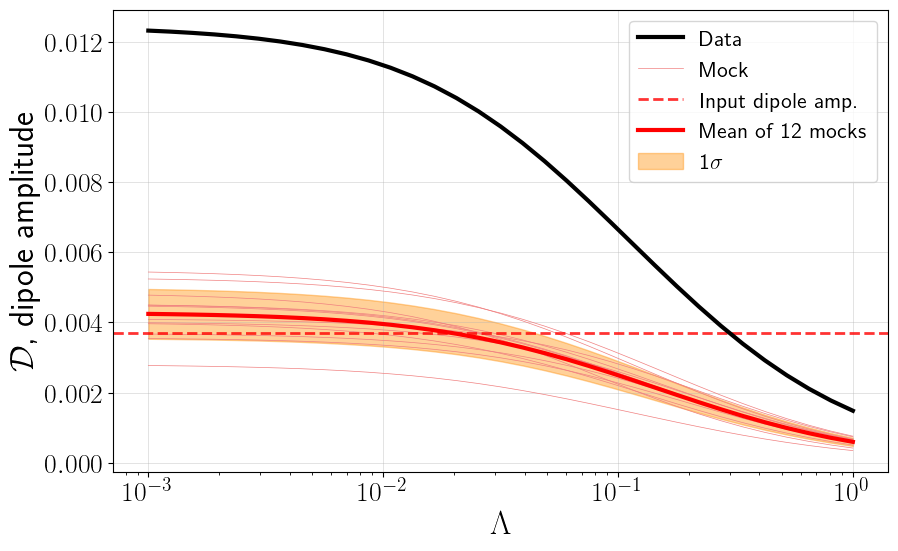

In [9]:
dir_results_mocks = '/scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise'
plot_dipole_comps_vs_Lambdas(case_dict_data, case_dicts_grid[0], dir_results_mocks=dir_results_mocks)
#plotter.plot_dipole_comps_vs_Lambdas(case_dict_data, case_dicts_grid[0])

In [10]:
len(case_dicts_grid)

200

In [11]:
case_dicts_grid[0]

{'Cell_mode': 'excess',
 'dipole_amp': 0.0037,
 'excess': 1e-06,
 'selfunc_mode': 'catwise_zodi',
 'base_rate': 72.42,
 'tag': '_case-excess-1.00e-06-catwise_zodi-0.0037-72.420'}

In [12]:
dipole_amps = [case_dict['dipole_amp'] for case_dict in case_dicts_grid]
excesses = [case_dict['excess'] for case_dict in case_dicts_grid]

In [13]:
import glob

def get_dipole_comps_mock(case_dict_mock, dir_results_mocks=None):

    RESULTDIR = '/scratch/aew492/lss-dipoles_results'

    dir_results_data = os.path.join(RESULTDIR, 'results/results_data')
    if dir_results_mocks is None:
        dir_results_mocks = os.path.join(RESULTDIR, 'results/results_mocks')

    # Load mock
    Lambdas_mocks = []
    dipole_amps_mocks = []
    pattern = f"{dir_results_mocks}/dipole_comps_lambdas*{case_dict_mock['tag']}*.npy"
    print(f"looking for {pattern}...")
    fn_comps_mock = glob.glob(pattern)
    n_trials = len(fn_comps_mock)
    print(f"found {n_trials} files with this pattern")

    if n_trials==0:
        return np.nan
    
    # not necessary in order, careful!
    for i in range(n_trials):
        result_dict = np.load(fn_comps_mock[i],  allow_pickle=True).item()
        dipole_amps_mock = np.linalg.norm(result_dict['dipole_comps'], axis=-1)
        dipole_amps_mocks.append(dipole_amps_mock)
        Lambdas_mocks.append(result_dict['Lambdas'])
    dipole_amps_mocks = np.array(dipole_amps_mocks)

    dipole_amps_mock_mean = np.mean(dipole_amps_mocks, axis=0)
    # for now, grab the smallest lambda
    i_minlambda = np.argmin(result_dict['Lambdas'])
    dipole_amp_minlambda = dipole_amps_mock_mean[i_minlambda]
    
    #dipole_amps_mock_std = np.std(dipole_amps_mocks, axis=0)
    return dipole_amp_minlambda

In [14]:
def get_dipole_comps_data(case_dict_data):
    RESULTDIR = '/scratch/aew492/lss-dipoles_results'

    dir_results_data = os.path.join(RESULTDIR, 'results/results_data')
    # Load data
    fn_comps_data = os.path.join(dir_results_data, f"dipole_comps_Lambdas_{case_dict_data['catalog_name']}{case_dict_data['tag']}.npy")
    result_dict = np.load(fn_comps_data, allow_pickle=True).item()
    dipole_comps_data = result_dict['dipole_comps']
    dipole_amps_data = np.linalg.norm(dipole_comps_data, axis=1)

    i_minlambda = np.argmin(result_dict['Lambdas'])
    dipole_amp_minlambda = dipole_amps_data[i_minlambda]
    
    #dipole_amps_mock_std = np.std(dipole_amps_mocks, axis=0)
    return dipole_amp_minlambda

# CatWISE

In [15]:
recovered_dipole_amps = []
for case_dict in case_dicts_grid:
    dipole_amps_mock_mean = get_dipole_comps_mock(case_dict, dir_results_mocks=dir_results_mocks)
    recovered_dipole_amps.append(dipole_amps_mock_mean)
recovered_dipole_amps = np.array(recovered_dipole_amps)
print(len(recovered_dipole_amps[~np.isnan(recovered_dipole_amps)]))

looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-1.00e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-1.67e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-2.78e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-4.64e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_catwise/dipole_comps_lambdas*_case-excess-7.74e-06-catwise_zodi-0.0037-72.420*.npy...
found 12 files with this pattern
looking for /scratch/aew492/ls

In [16]:
recovered_dipole_amps.shape

(200,)

In [17]:
dipole_amp_data = get_dipole_comps_data(case_dict_data)
dipole_amp_data

0.012321310897772301

In [18]:
rmin = np.min(recovered_dipole_amps[~np.isnan(recovered_dipole_amps)])
rmax = np.max(recovered_dipole_amps[~np.isnan(recovered_dipole_amps)])
rwidth = max(np.abs(dipole_amp_data-rmin), np.abs(dipole_amp_data-rmax))
norm = matplotlib.colors.TwoSlopeNorm(vmin=dipole_amp_data-rwidth, 
                                      vcenter=dipole_amp_data, 
                                      vmax=dipole_amp_data+rwidth)
print(rmin, rmax, dipole_amp_data, dipole_amp_data-rwidth, dipole_amp_data+rwidth)

0.004244321568308398 0.025878523308064023 0.012321310897772301 -0.0012359015125194203 0.025878523308064023


Text(0, 0.5, 'input excess power')

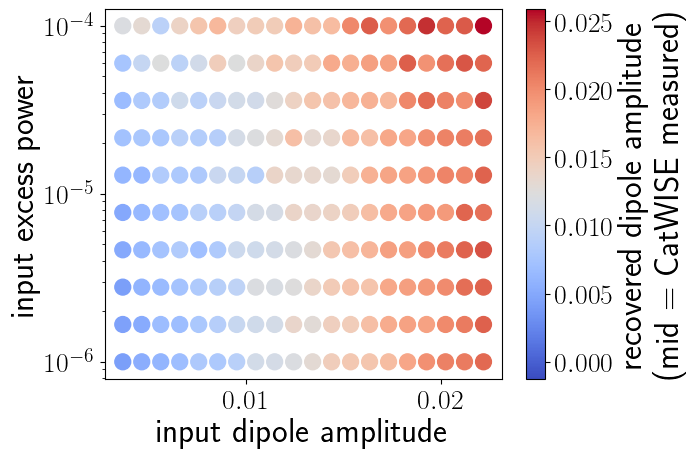

In [19]:
plt.scatter(dipole_amps, excesses, c=recovered_dipole_amps, cmap='coolwarm', norm=norm, s=130)
plt.yscale('log')
plt.colorbar(label='recovered dipole amplitude\n(mid = CatWISE measured)')
plt.xlabel('input dipole amplitude')
plt.ylabel('input excess power')

Text(0, 0.5, 'recovered dipole amplitude')

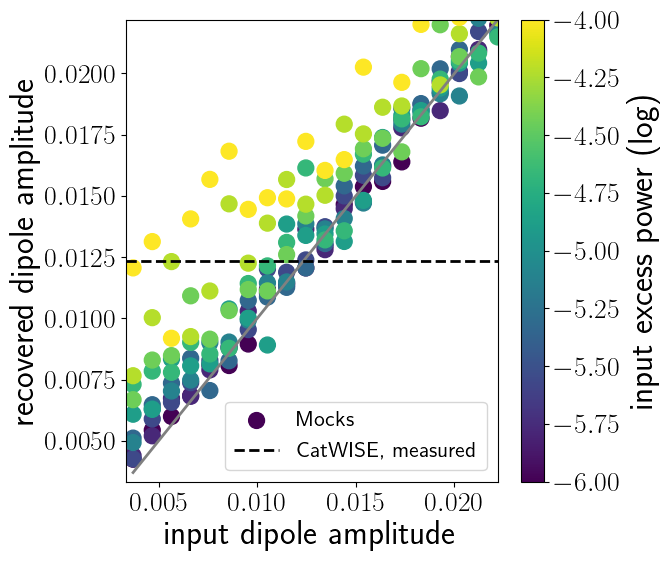

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(dipole_amps, recovered_dipole_amps, c=np.log10(excesses), s=130, label='Mocks')
plt.plot(dipole_amps, dipole_amps, color='grey')

plt.axhline(dipole_amp_data, label='CatWISE, measured', color='black', ls='--')

plt.xlim(0.9*np.min(dipole_amps), np.max(dipole_amps))
plt.ylim(0.9*np.min(dipole_amps), np.max(dipole_amps))

plt.legend()
plt.colorbar(label='input excess power (log)')
plt.xlabel('input dipole amplitude')
plt.ylabel('recovered dipole amplitude')


In [69]:

def get_Cells_mocks(case_dicts_mock, Lambda,
                title='', fn_fig=None, ms=7, max_mocks=12,
                dir_results_mocks=None,
                verbose=False):

    RESULTDIR = '/scratch/aew492/lss-dipoles_results'

    if dir_results_mocks is None:
        dir_results_mocks = os.path.join(RESULTDIR, 'results/results_mocks')

    ells_mocks_arr = []
    Cells_mocks_arr = []
    #print("here")
    for case_dict_mock in case_dicts_mock:
        #print(case_dict_mock['excess'])
        # Load mock
        ells_mocks = []
        Cells_mocks = []
        pattern = f"{dir_results_mocks}/Cells_Lambda-{Lambda:.1e}*{case_dict_mock['tag']}*.npy"
        if verbose:
            print(f"looking for {pattern}")
        fn_comps_mock = glob.glob(pattern)
        fn_comps_mock = tools.filter_max_mocks(fn_comps_mock, max_mocks)
        n_trials = len(fn_comps_mock)
        if verbose:
            print(f"loaded {n_trials} mocks")

        # not necessary in order, careful!
        for i in range(n_trials):
            result_dict = np.load(fn_comps_mock[i],  allow_pickle=True).item()
            Cells_mocks.append(result_dict['Cells'])
            ells_mocks.append(result_dict['ells'])
        Cells_mocks = np.array(Cells_mocks)

        ells_mocks_arr.append(ells_mocks)
        Cells_mocks_arr.append(Cells_mocks)

    ells_mocks_arr = np.array(ells_mocks_arr)
    Cells_mocks_arr = np.array(Cells_mocks_arr)

    return ells_mocks_arr, Cells_mocks_arr


In [70]:
def get_Cells_data(case_dict_data, Lambda,
                title='', fn_fig=None, ms=7, 
                dir_results_data=None,
                verbose=False):

    RESULTDIR = '/scratch/aew492/lss-dipoles_results'

    if dir_results_data is None:
        dir_results_data = os.path.join(RESULTDIR, 'results/results_data')

    fn_comps_data = os.path.join(dir_results_data,
                        f"Cells_Lambda-{Lambda:.1e}_{case_dict_data['catalog_name']}{case_dict_data['tag']}.npy")
    result_dict = np.load(fn_comps_data, allow_pickle=True).item()
    Cells_data = result_dict['Cells']
    ells_data = result_dict['ells']

    return ells_data, Cells_data

In [66]:
import tools

def plot_Cells(case_dict_data, case_dicts_mock, Lambda,
                title='', fn_fig=None, ms=7, max_mocks=12,
              dir_results_data=None, dir_results_mocks=None,
              verbose=False):

    RESULTDIR = '/scratch/aew492/lss-dipoles_results'

    if dir_results_data is None:
        dir_results_data = os.path.join(RESULTDIR, 'results/results_data')
    if dir_results_mocks is None:
        dir_results_mocks = os.path.join(RESULTDIR, 'results/results_mocks')

    # Create figure
    plt.figure(figsize=(10, 6))

    # plot params
    marker = 'o'

    excesses = [case_dict['excess'] for case_dict in case_dicts_mock]
    
    locs_norm = matplotlib.colors.Normalize(np.min(np.log10(excesses)), np.max(np.log10(excesses)))
    cmap = matplotlib.colormaps['viridis']
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)

    #print("here")
    for case_dict_mock in case_dicts_mock:
        #print(case_dict_mock['excess'])

        # Load data
        fn_comps_data = os.path.join(dir_results_data,
                            f"Cells_Lambda-{Lambda:.1e}_{case_dict_data['catalog_name']}{case_dict_data['tag']}.npy")
        result_dict = np.load(fn_comps_data, allow_pickle=True).item()
        Cells_data = result_dict['Cells']
        ells_data = result_dict['ells']
        #print("loaded")

        # Load mock
        ells_mocks = []
        Cells_mocks = []
        pattern = f"{dir_results_mocks}/Cells_Lambda-{Lambda:.1e}*{case_dict_mock['tag']}*.npy"
        if verbose:
            print(f"looking for {pattern}")
        fn_comps_mock = glob.glob(pattern)
        fn_comps_mock = tools.filter_max_mocks(fn_comps_mock, max_mocks)
        n_trials = len(fn_comps_mock)
        if verbose:
            print(f"loaded {n_trials} mocks")

        # not necessary in order, careful!
        for i in range(n_trials):
            result_dict = np.load(fn_comps_mock[i],  allow_pickle=True).item()
            Cells_mocks.append(result_dict['Cells'])
            ells_mocks.append(result_dict['ells'])
        Cells_mocks = np.array(Cells_mocks)

        # Plot data
        plt.plot(ells_data, Cells_data, mec='k', c='None', ls='None', marker=marker, ms=ms*2,
                    label=r'Data, $\Lambda=$'f'{Lambda:.1e}', zorder=100)

        # Plot each mock trial with light red lines
        # for i in range(n_trials):        
        #     label = r'Mock, $\Lambda=$'f'{Lambda:.1e}' if i==0 else ''
        #     plt.plot(ells_mocks[i], Cells_mocks[i], color='lightcoral', marker=markers[j], ms=ms,
        #             ls='None', label=label)

        # Plot the mean of the mock data with a dark red line
        Cells_mock_mean = np.mean(Cells_mocks, axis=0)
        Cells_mock_std = np.std(Cells_mocks, axis=0)
        # plt.plot(ells_mocks[0], Cells_mock_mean, color='red', marker=markers[j], ms=ms,
        #         ls='None', label='Mock mean, 'r'$\Lambda=$'f'{Lambda:.1e}', zorder=50)



        plt.errorbar(ells_mocks[0], Cells_mock_mean, yerr=Cells_mock_std, color=cmap(locs_norm(np.log10(case_dict_mock['excess']))),
                marker=marker, ms=ms,
                ls='None', label='Mock mean, 'r'$\Lambda=$'f'{Lambda:.1e}', zorder=50)

    #print("finishing plotting")
    # Adding grid, labels and legend
    plt.grid(alpha=0.5, lw=0.5)
    plt.yscale('log')
    #plt.colorbar(label='excess power')

    ax = plt.gca()
    plt.colorbar(sm, ax=ax, label='excess power')
    #fig = plt.gcf()
    #fig.colorbar(sm, ax=er, label='Value')

    
    plt.xlabel(r'Multipole $\ell$')
    plt.ylabel(r'$C(\ell)$')
    plt.title(title)
    #plt.legend()

    if fn_fig is not None:
        plt.savefig(fn_fig, bbox_inches='tight')
        print(f"Saved figure to {fn_fig}")

In [22]:
case_dicts_grid[0]['dipole_amp']

0.0037

10
here
1e-06
loaded
loaded mock
1.6681005372000591e-06
loaded
loaded mock
2.782559402207126e-06
loaded
loaded mock
4.641588833612782e-06
loaded
loaded mock
7.742636826811277e-06
loaded
loaded mock
1.2915496650148827e-05
loaded
loaded mock
2.154434690031882e-05
loaded
loaded mock
3.5938136638046256e-05
loaded
loaded mock
5.994842503189409e-05
loaded
loaded mock
9.999999999999999e-05
loaded
loaded mock
finishing plotting


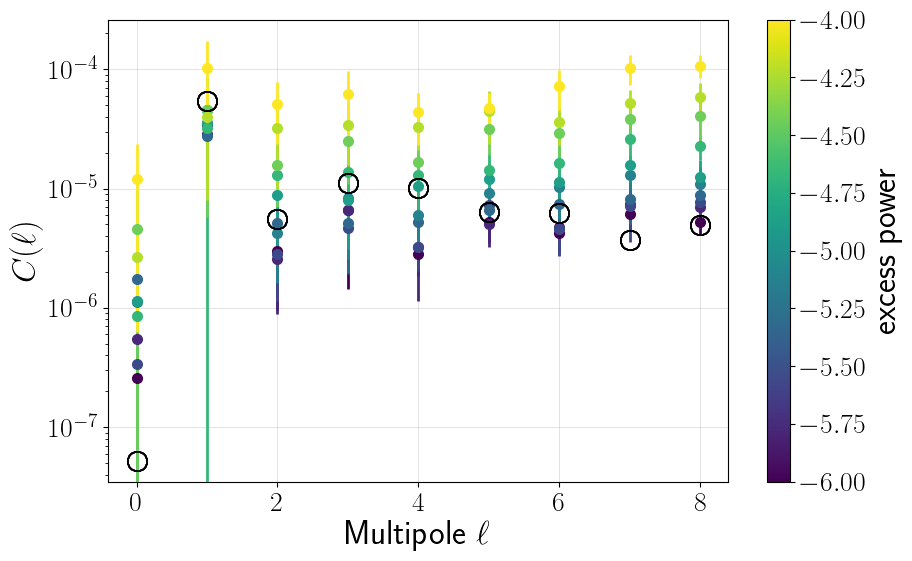

In [23]:
Lambda = 1e-2
tol = 1e-4
case_dicts = [case_dict for case_dict in case_dicts_grid if np.abs(case_dict['dipole_amp']-0.0075947368421052635)<tol]
print(len(case_dicts))
plot_Cells(case_dict_data, case_dicts, Lambda,
                title='', fn_fig=None, ms=7, max_mocks=12,
              dir_results_data=None, dir_results_mocks=dir_results_mocks)

10


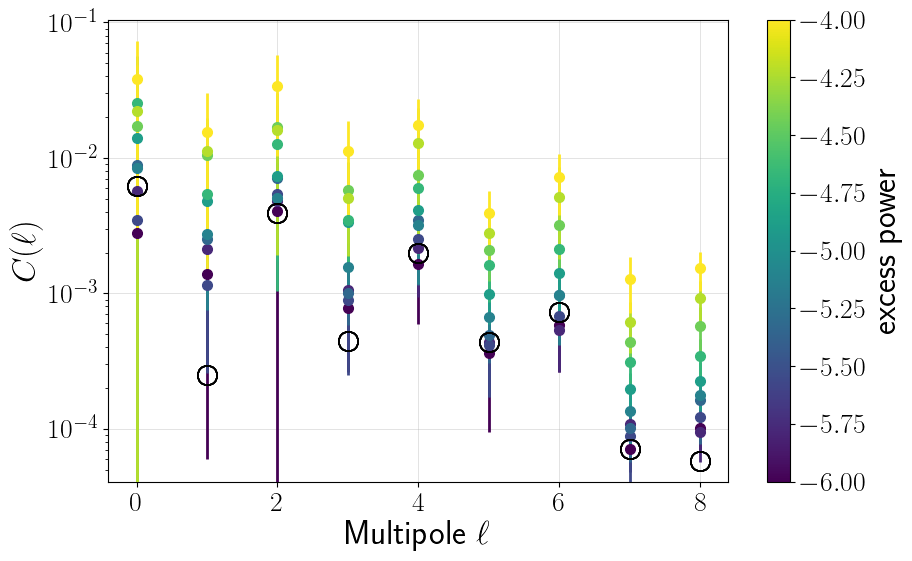

In [79]:
Lambda = 0.0
tol = 1e-4
case_dicts = [case_dict for case_dict in case_dicts_grid if np.abs(case_dict['dipole_amp']-0.0075947368421052635)<tol]
print(len(case_dicts))
plot_Cells(case_dict_data, case_dicts, Lambda,
                title='', fn_fig=None, ms=7, max_mocks=None,
              dir_results_data=None, dir_results_mocks=dir_results_mocks)

# Quaia

In [26]:
n_amps = 20
n_excess = 10
case_dicts_grid_quaia = gm.grid_case_set('grid_quaia', n_amps, n_excess)

In [27]:
set_name = 'ideal_quaia'
tag_fig = f'_{set_name}'
catalog_name = 'quaia_G20.0'
selfunc_mode = 'quaia_G20.0_orig'
case_dict_data_quaia = {
    "catalog_name": catalog_name,
    "selfunc_mode": selfunc_mode, #this also multiplies in the mask
    "tag": f"_case-{selfunc_mode}"
}

In [28]:
dir_results_mocks_quaia = '/scratch/aew492/lss-dipoles_results/results/results_mocks/grid_quaia'


In [29]:
dipole_amps_quaia = [case_dict['dipole_amp'] for case_dict in case_dicts_grid_quaia]
excesses_quaia = [case_dict['excess'] for case_dict in case_dicts_grid_quaia]

In [30]:
dipole_amp_data_quaia = get_dipole_comps_data(case_dict_data_quaia)
dipole_amp_data_quaia

0.015065381681838354

In [31]:
recovered_dipole_amps_quaia = []
for case_dict in case_dicts_grid_quaia:
    dipole_amps_mock_mean = get_dipole_comps_mock(case_dict, dir_results_mocks=dir_results_mocks_quaia)
    recovered_dipole_amps_quaia.append(dipole_amps_mock_mean)
recovered_dipole_amps_quaia = np.array(recovered_dipole_amps_quaia)
print(len(recovered_dipole_amps_quaia[~np.isnan(recovered_dipole_amps_quaia)]))

looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_quaia/dipole_comps_lambdas*_case-excess-1.00e-06-quaia_G20.0_orig-0.0026-33.640*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_quaia/dipole_comps_lambdas*_case-excess-1.67e-06-quaia_G20.0_orig-0.0026-33.640*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_quaia/dipole_comps_lambdas*_case-excess-2.78e-06-quaia_G20.0_orig-0.0026-33.640*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_quaia/dipole_comps_lambdas*_case-excess-4.64e-06-quaia_G20.0_orig-0.0026-33.640*.npy...
found 12 files with this pattern
looking for /scratch/aew492/lss-dipoles_results/results/results_mocks/grid_quaia/dipole_comps_lambdas*_case-excess-7.74e-06-quaia_G20.0_orig-0.0026-33.640*.npy...
found 12 files with this pattern
looking for /scratch

In [32]:
rmin = np.min(recovered_dipole_amps_quaia[~np.isnan(recovered_dipole_amps_quaia)])
rmax = np.max(recovered_dipole_amps_quaia[~np.isnan(recovered_dipole_amps_quaia)])
rwidth = max(np.abs(dipole_amp_data_quaia-rmin), np.abs(dipole_amp_data_quaia-rmax))
norm = matplotlib.colors.TwoSlopeNorm(vmin=dipole_amp_data_quaia-rwidth, 
                                      vcenter=dipole_amp_data_quaia, 
                                      vmax=dipole_amp_data_quaia+rwidth)
print(rmin, rmax, dipole_amp_data_quaia, dipole_amp_data_quaia-rwidth, dipole_amp_data_quaia+rwidth)

0.004160382766594122 0.021112261660357082 0.015065381681838354 0.004160382766594122 0.025970380597082586


Text(0, 0.5, 'input excess power')

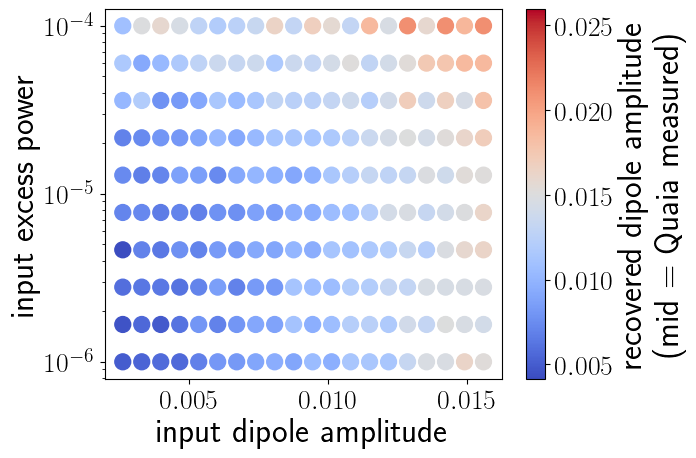

In [33]:
plt.scatter(dipole_amps_quaia, excesses_quaia, c=recovered_dipole_amps_quaia, cmap='coolwarm', norm=norm, s=130)
plt.yscale('log')
plt.colorbar(label='recovered dipole amplitude\n(mid = Quaia measured)')
plt.xlabel('input dipole amplitude')
plt.ylabel('input excess power')

Text(0, 0.5, 'recovered dipole amplitude')

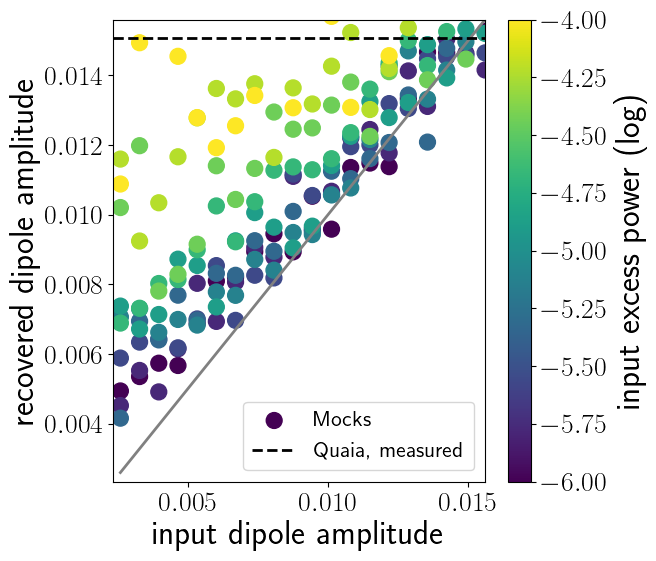

In [34]:
plt.figure(figsize=(6,6))
plt.scatter(dipole_amps_quaia, recovered_dipole_amps_quaia, c=np.log10(excesses), s=130, label='Mocks')
plt.plot(dipole_amps_quaia, dipole_amps_quaia, color='grey')

plt.axhline(dipole_amp_data_quaia, label='Quaia, measured', color='black', ls='--')

plt.xlim(0.9*np.min(dipole_amps_quaia), np.max(dipole_amps_quaia))
plt.ylim(0.9*np.min(dipole_amps_quaia), np.max(dipole_amps_quaia))

plt.legend()
plt.colorbar(label='input excess power (log)')
plt.xlabel('input dipole amplitude')
plt.ylabel('recovered dipole amplitude')


(array([13., 12., 12., 11.,  8., 12.,  5., 10.,  7., 10., 11.,  3.,  8.,
         4.,  2.,  9., 11.,  5.,  7.,  6.,  3.,  6., 10.,  4.,  2.,  3.,
         2.,  2.,  0.,  2.]),
 array([0.00189903, 0.02596389, 0.05002875, 0.07409361, 0.09815847,
        0.12222333, 0.14628819, 0.17035305, 0.19441791, 0.21848277,
        0.24254763, 0.26661249, 0.29067736, 0.31474222, 0.33880708,
        0.36287194, 0.3869368 , 0.41100166, 0.43506652, 0.45913138,
        0.48319624, 0.5072611 , 0.53132596, 0.55539082, 0.57945568,
        0.60352054, 0.62758541, 0.65165027, 0.67571513, 0.69977999,
        0.72384485]),
 [<matplotlib.patches.Polygon at 0x1456511401d0>])

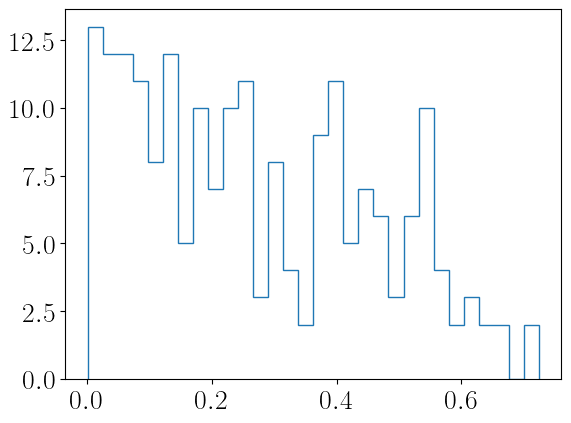

In [50]:
frac_diffs_quaia = np.abs(recovered_dipole_amps_quaia - dipole_amp_data_quaia)/dipole_amp_data_quaia
plt.hist(frac_diffs_quaia, bins=30, histtype='step')

In [55]:
# get cases where recovered within 10%
idxs_close_quaia = np.where(frac_diffs_quaia < 0.02)[0]
print(len(idxs_close_quaia))

11


In [56]:
dipole_amp_data_quaia

0.015065381681838354

In [57]:
recovered_dipole_amps_quaia[idxs_close_quaia]

array([0.01493627, 0.01522929, 0.01500233, 0.01488181, 0.01503677,
       0.01477452, 0.01525663, 0.01496537, 0.01533298, 0.01526269,
       0.01520363])

11


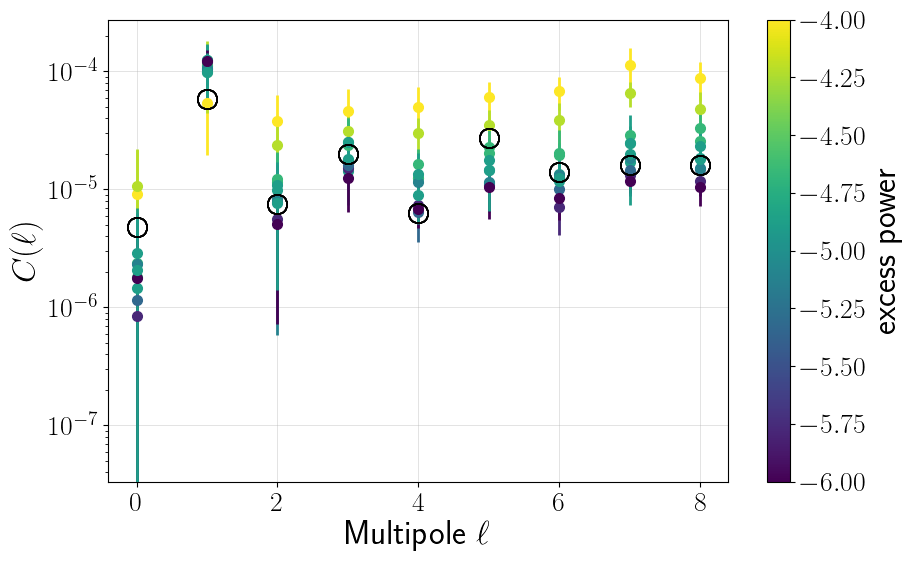

In [67]:
Lambda = 1e-2

case_dicts = [case_dicts_grid_quaia[i] for i in idxs_close_quaia]
print(len(case_dicts))
plot_Cells(case_dict_data_quaia, case_dicts, Lambda,
                title='', fn_fig=None, ms=7, max_mocks=None,
              dir_results_data=None, dir_results_mocks=dir_results_mocks_quaia)

11


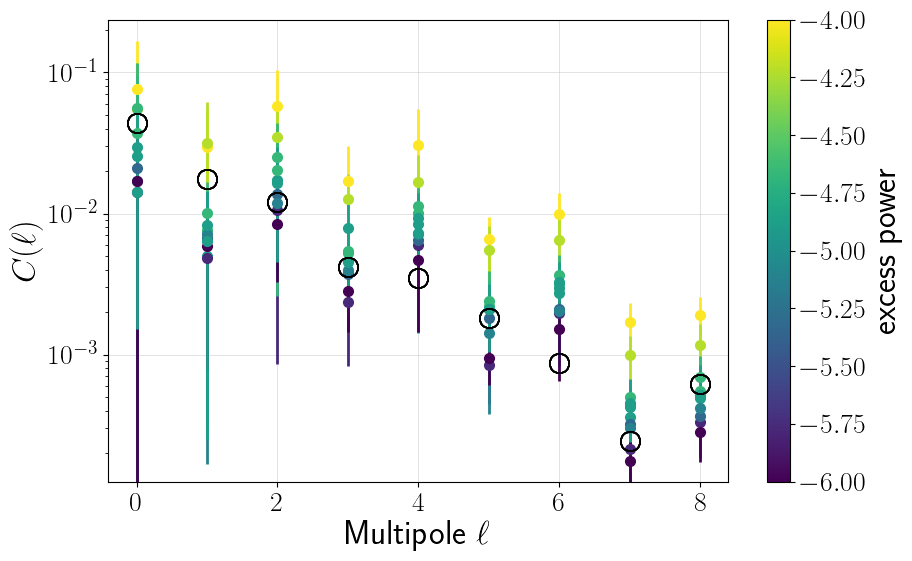

In [68]:
Lambda = 0.0

case_dicts = [case_dicts_grid_quaia[i] for i in idxs_close_quaia]
print(len(case_dicts))
plot_Cells(case_dict_data_quaia, case_dicts, Lambda,
                title='', fn_fig=None, ms=7, max_mocks=None,
              dir_results_data=None, dir_results_mocks=dir_results_mocks_quaia)

In [72]:
Lambda = 1e-2
ells_mocks_arr_quaia, Cells_mocks_arr_quaia = get_Cells_mocks(case_dicts, Lambda,
                                   max_mocks=None)

In [73]:
ells_data_quaia, Cells_data_quaia = get_Cells_data(case_dict_data_quaia, Lambda)

In [76]:
likes = []
for i in range(len(Cells_mocks_arr_quaia)):
    like = -0.5 * np.sum((Cells_mocks_arr_quaia[i] - Cells_data_quaia ** 2) / variance)
    likes.append(like)

ValueError: operands could not be broadcast together with shapes (0,) (9,) 